In [3]:
# Essential imports for image work with NumPy in a Jupyter cell
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [29]:
def read_image(path, as_gray=False):
    """
    Read image from path and return a NumPy array.
    - Colored images are returned as RGB uint8 arrays.
    - If as_gray=True, returns a single-channel uint8 array.
    Raises FileNotFoundError if the path is invalid.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")

    # If grayscale requested
    if as_gray:
        if img.ndim == 3:
            return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

    # If already single channel, return as-is
    if img.ndim == 2:
        return img

    # Convert BGR (cv2) -> RGB
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return rgb_img


def show_image(img, title=None, figsize=(6, 6)):
    """
    Display an image (NumPy array) in the notebook.
    Handles RGB (H,W,3) and grayscale (H,W). Accepts uint8 or float images.
    """
    img_disp = img
    # If float image in [0,1], scale to 0-255 for consistent display
    if getattr(img, "dtype", None) is not None and img.dtype.kind == "f":
        if img.max() <= 1.0:
            img_disp = (img * 255).astype("uint8")
        else:
            img_disp = np.clip(img, 0, 255).astype("uint8")

    plt.figure(figsize=figsize)
    if img_disp.ndim == 3 and img_disp.shape[2] == 3:
        plt.imshow(img_disp)
    else:
        plt.imshow(img_disp, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def save_image(path, img):
    """
    Save a NumPy array as an image to the specified path.
    Handles RGB (H,W,3) and grayscale (H,W). Accepts uint8 or float images.
    """
    img_to_save = img
    # If float image in [0,1], scale to 0-255 for saving
    if getattr(img, "dtype", None) is not None and img.dtype.kind == "f":
        if img.max() <= 1.0:
            img_to_save = (img * 255).astype("uint8")
        else:
            img_to_save = np.clip(img, 0, 255).astype("uint8")

    # Convert RGB to BGR for OpenCV
    if img_to_save.ndim == 3 and img_to_save.shape[2] == 3:
        img_to_save = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)

    cv2.imwrite(path, img_to_save)

def compute_image_edges_(img):
    """
    Compute the first-order derivatives of a grayscale image using Sobel filters.
    Returns the gradients in x and y directions as NumPy arrays.
    """
    if img.ndim != 2:
        raise ValueError("Input image must be grayscale (2D array).")
    
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad = grad / np.max(grad)  # Normalize to [0, 1]

    # Thresholding to create binary edge map
    threshold = 0.5

    sigmoid = lambda x: 1 / (1 + np.exp(-6 * (x - threshold)))
    grad = sigmoid(grad)

    return grad

def compute_image_edges(img, low_threshold=100, high_threshold=200, sigma=1.4, kernel_size=3):
    """
    Compute image edges using Canny edge detection.
    """
    if img.ndim == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    img_blurred = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), sigma)
    edges = cv2.Canny(img_blurred, low_threshold, high_threshold)

    return edges

In [30]:
def save_borders(file_name):
    img = read_image(f"instancias/{file_name}") / 255.0

    H,W = img.shape[0:2]
    print(f"Dimensiones de la imagen: {H} x {W}")

    show_image(img, title=f"Imagen de {file_name.split('.')[0].capitalize()}")


    img_gray = read_image(f"instancias/{file_name}", as_gray=True)
    # show_image(img_gray, title="Imagen de Bach en escala de grises")

    img_grad_gray = compute_image_edges_(img_gray)
    img_gray_grad = img_grad_gray / np.max(img_grad_gray)

    show_image(img_gray, title="Imagen en escala de grises")
    show_image(img_grad_gray, title="Magnitud del Gradiente (Gray scale)")

    save_image(f"borders/{file_name}", img_gray_grad)

Procesando bach.png...
Dimensiones de la imagen: 64 x 48


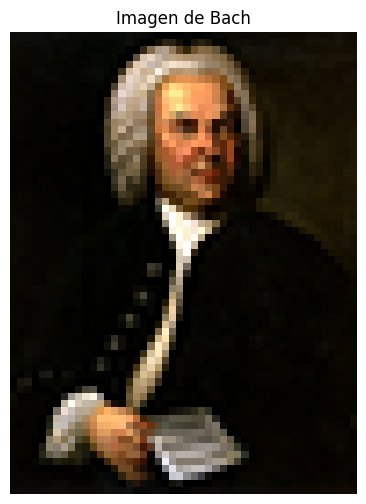

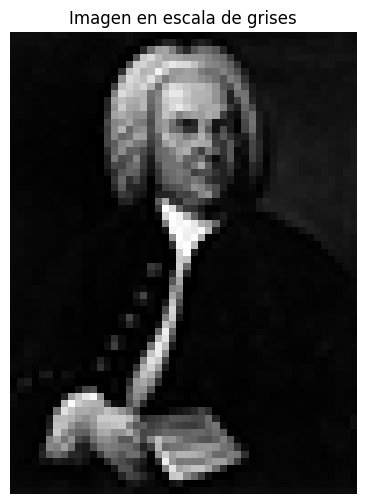

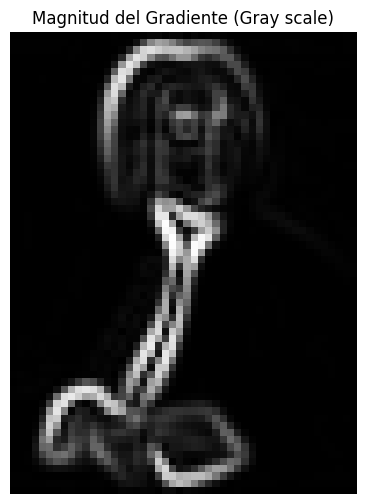

Procesando dali.png...
Dimensiones de la imagen: 48 x 64


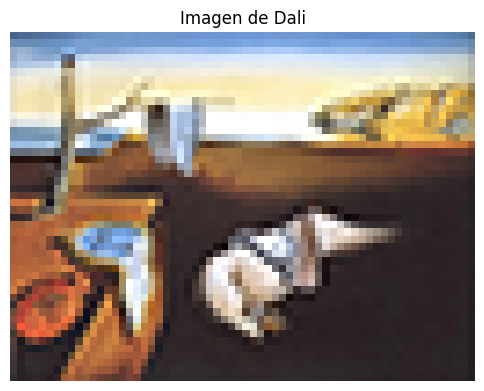

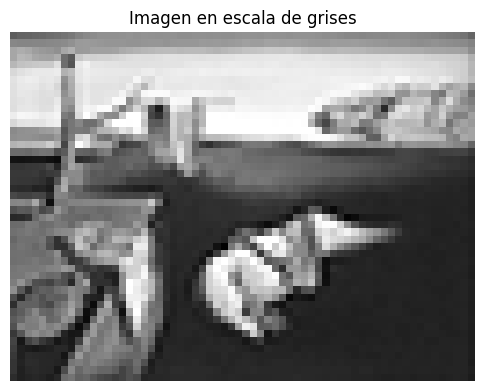

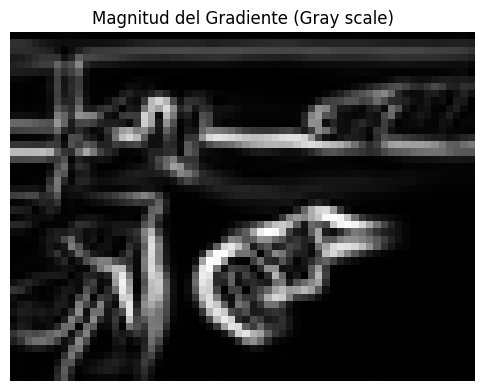

Procesando klimt.png...
Dimensiones de la imagen: 64 x 48


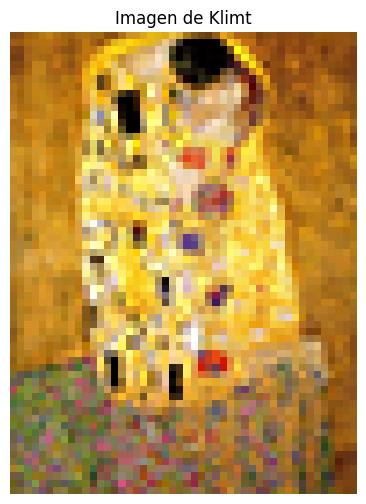

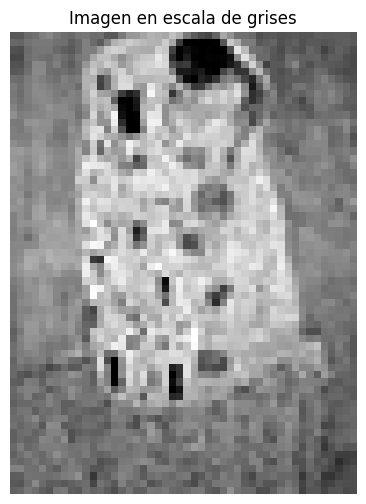

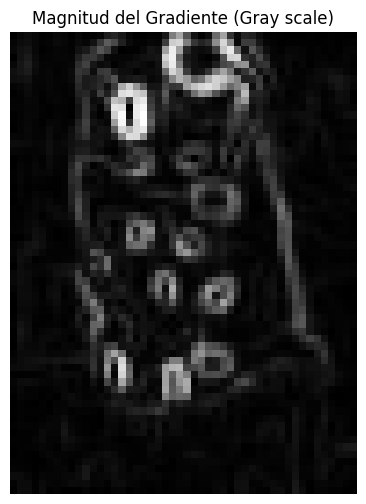

Procesando mona.png...
Dimensiones de la imagen: 64 x 48


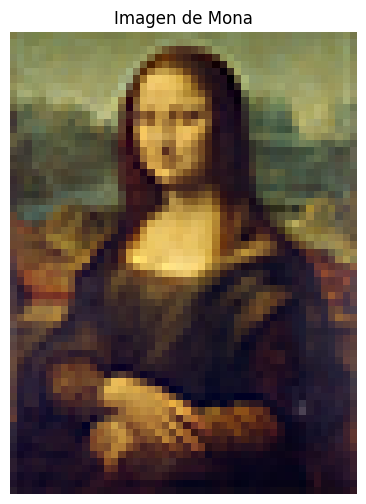

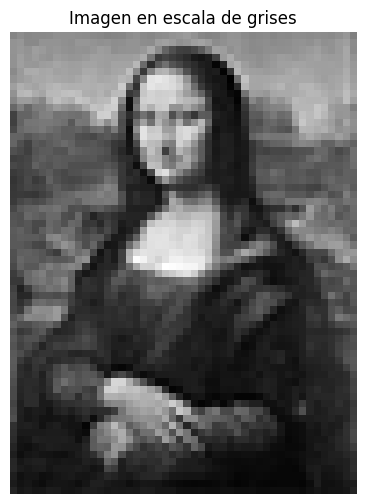

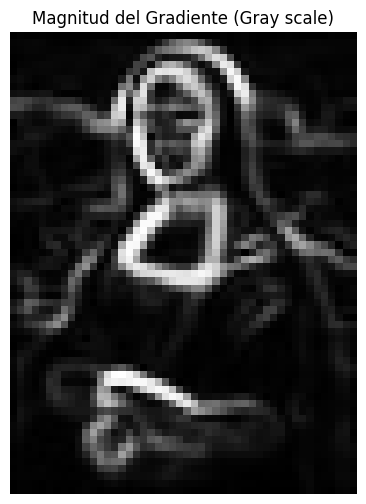

Procesando mondriaan.png...
Dimensiones de la imagen: 64 x 48


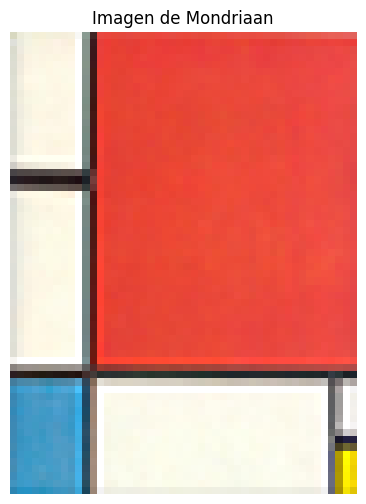

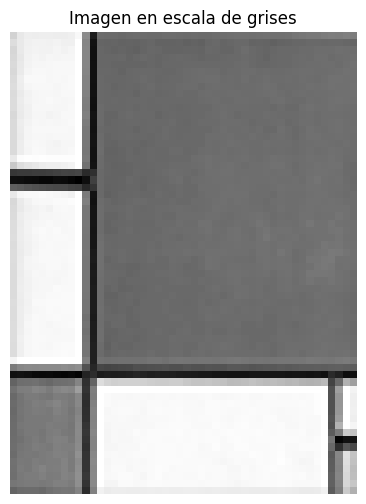

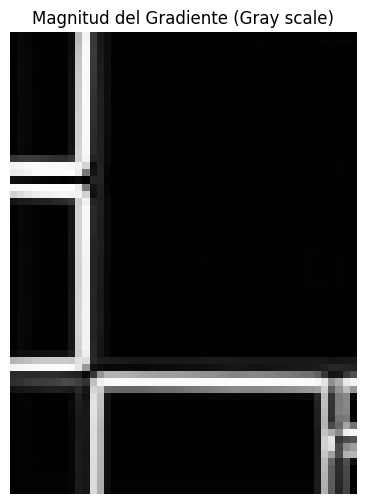

Procesando pollock.png...
Dimensiones de la imagen: 48 x 64


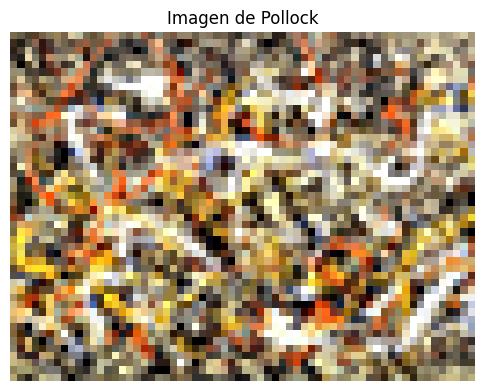

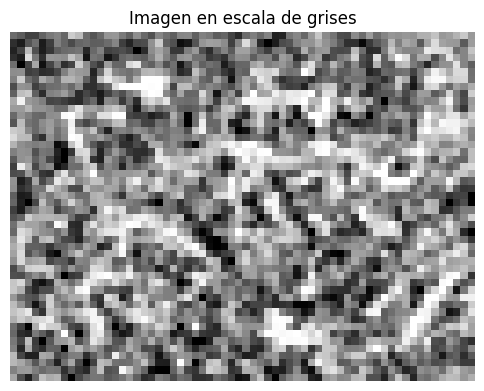

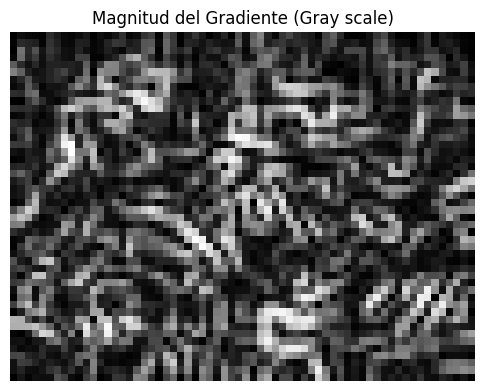

Procesando starrynight.png...
Dimensiones de la imagen: 48 x 64


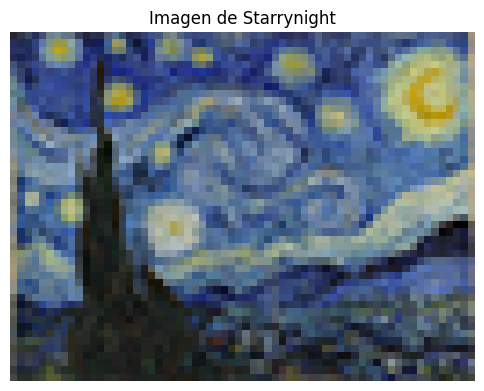

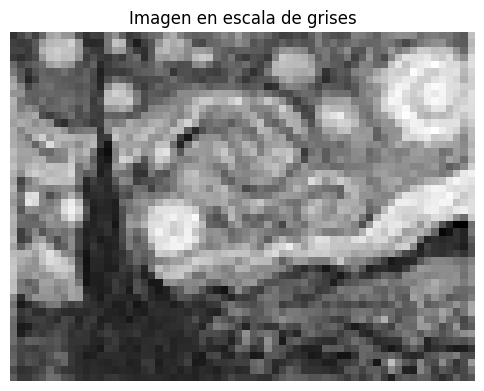

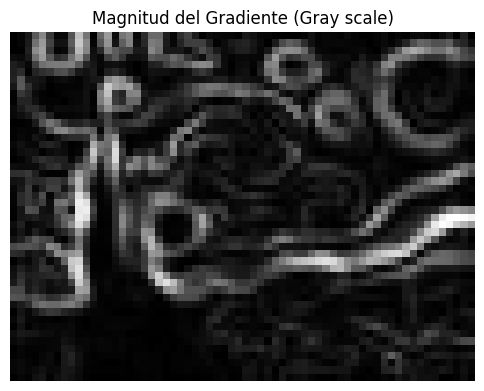

In [31]:
# Loop over target images in "instancias/" and save borders to "borders/"
import os

for file_name in os.listdir("instancias/"):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        print(f"Procesando {file_name}...")
        save_borders(file_name)

In [7]:
for file_name in os.listdir("output/"):
    if file_name.lower().endswith(('.png')):
        out = read_image(f"output/{file_name}")
        target = read_image(f"instancias/{file_name.split('_')[-1]}")

        # Show output and target side by side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(out)
        axs[0].set_title(file_name)
        axs[0].axis("off")
        axs[1].imshow(target)
        axs[1].set_title("Target Image")
        axs[1].axis("off")
        plt.show()

        diff = np.abs(out - target)

        # Show difference by channel and the mean difference
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        axs[0].imshow(diff[:,:,0], cmap='gray')
        axs[0].set_title("Red Channel Difference")
        axs[0].axis("off")
        axs[1].imshow(diff[:,:,1], cmap='gray')
        axs[1].set_title("Green Channel Difference")
        axs[1].axis("off")
        axs[2].imshow(diff[:,:,2], cmap='gray')
        axs[2].set_title("Blue Channel Difference")
        axs[2].axis("off")
        mean_diff = np.mean(diff, axis=2)
        axs[3].imshow(mean_diff, cmap='gray')
        axs[3].set_title("Mean Difference")
        axs[3].axis("off")
        plt.show()

In [8]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np

def meanshift_segment(img, bandwidth=None, sample_fraction=0.1, use_spatial=False, spatial_scale=1.0,
                      bin_seeding=True, max_samples_for_fit=200000):
    """
    Segment an RGB image using scikit-learn's MeanShift.
    - img: HxWx3 uint8 or float image (RGB).
    - bandwidth: if None, estimated from a sample of the data.
    - sample_fraction: fraction of pixels to sample for bandwidth estimation / fitting when image is large.
    - use_spatial: if True, append (x,y) coordinates to feature vector (weighted by spatial_scale).
    - spatial_scale: multiplier applied to normalized spatial coordinates to control spatial influence.
    - bin_seeding: passed to MeanShift.
    - max_samples_for_fit: upper limit on number of points used to fit MeanShift.
    Returns (segmented_img_uint8, labels_2d, cluster_centers_rgb_float).
    """
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Input must be an RGB image (H,W,3).")

    H, W = img.shape[:2]
    # ensure float features in a reasonable range
    img_arr = img.astype("float32")
    if img_arr.max() > 1.0:
        img_arr /= 255.0

    # build feature array: color channels + optional spatial coords
    coords_y, coords_x = np.indices((H, W))
    feats_color = img_arr.reshape(-1, 3)
    if use_spatial:
        nx = coords_x.reshape(-1) / max(1, W - 1)
        ny = coords_y.reshape(-1) / max(1, H - 1)
        nx = nx * spatial_scale
        ny = ny * spatial_scale
        feats = np.column_stack([feats_color, nx, ny])
    else:
        feats = feats_color

    n_samples = feats.shape[0]

    # decide how many points to use for fitting
    if n_samples > max_samples_for_fit:
        # always limit to max_samples_for_fit
        idx = np.random.choice(n_samples, size=max_samples_for_fit, replace=False)
        fit_feats = feats[idx]
    elif (sample_fraction < 1.0) and (n_samples * sample_fraction < n_samples):
        k = max(1000, int(n_samples * sample_fraction))
        idx = np.random.choice(n_samples, size=k, replace=False)
        fit_feats = feats[idx]
    else:
        fit_feats = feats

    # estimate bandwidth if not provided
    if bandwidth is None:
        # estimate_bandwidth can be slow on huge data; we use fit_feats which is already sampled
        bandwidth = estimate_bandwidth(fit_feats, quantile=0.1, n_samples=min(10000, fit_feats.shape[0]))

    # fit MeanShift on the sampled data (or whole data if small)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=bin_seeding)
    ms.fit(fit_feats)

    # assign labels for all pixels using the fitted cluster centers
    labels = ms.predict(feats)  # uses cluster_centers_ internally
    labels_2d = labels.reshape(H, W)

    # map each label to the RGB center (we stored RGB in the first 3 dims of cluster centers)
    centers = ms.cluster_centers_
    # If spatial was used, centers include spatial dims at the end; take first 3 for color
    centers_rgb = centers[:, :3]
    # create segmented image
    segmented = centers_rgb[labels].reshape(H, W, 3)

    # convert back to uint8 range 0-255
    segmented_uint8 = np.clip((segmented * 255.0).round(), 0, 255).astype("uint8")

    return segmented_uint8, labels_2d, centers_rgb

Using image: bach.png


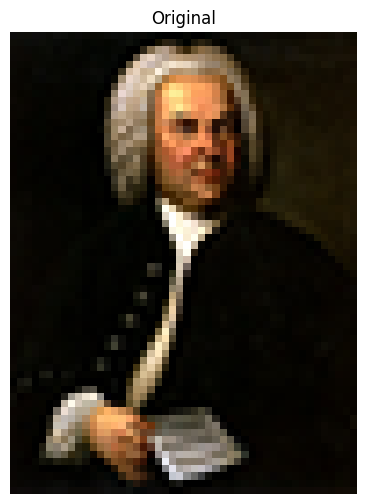

Found 10 clusters


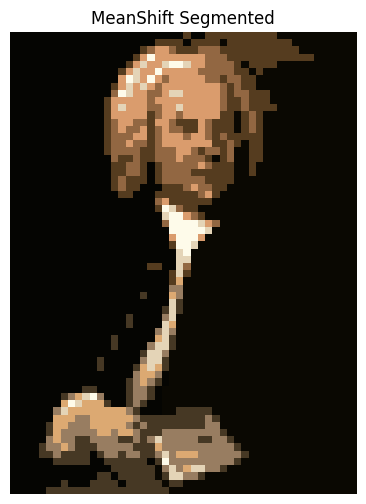

Saved segmented image to output/meanshift_bach.png
Using image: dali.png


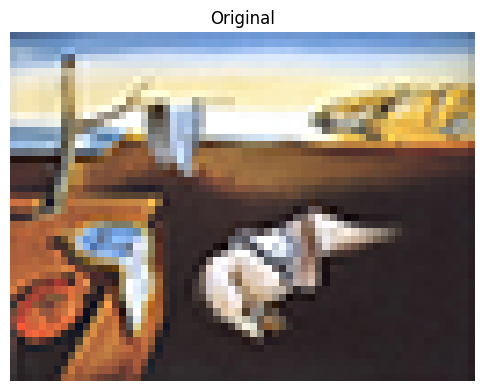

Found 6 clusters


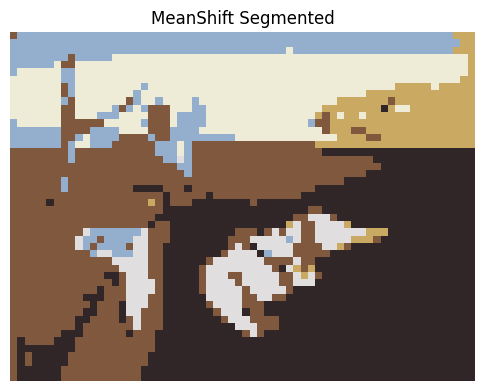

Saved segmented image to output/meanshift_dali.png
Using image: klimt.png


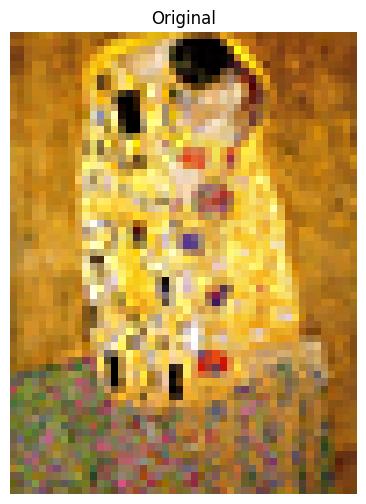

Found 7 clusters


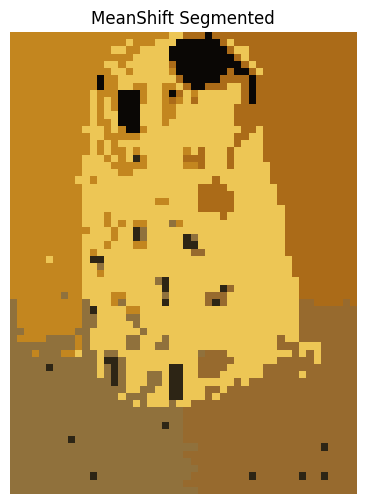

Saved segmented image to output/meanshift_klimt.png
Using image: mona.png


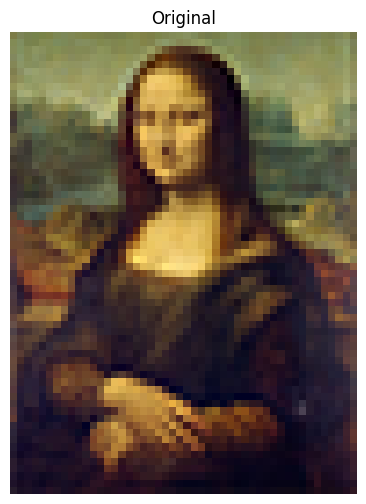

Found 6 clusters


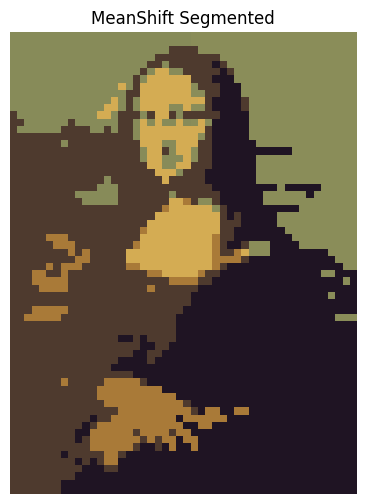

Saved segmented image to output/meanshift_mona.png
Using image: mondriaan.png


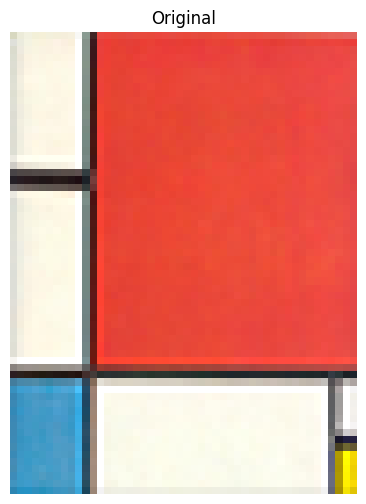

Found 11 clusters


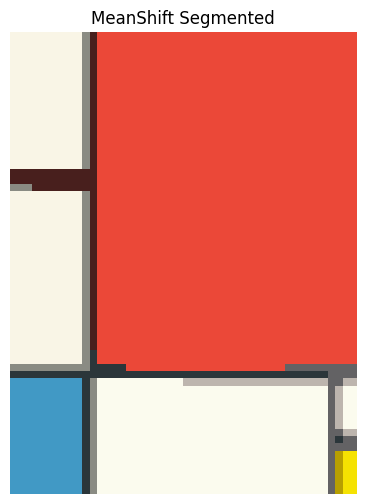

Saved segmented image to output/meanshift_mondriaan.png
Using image: pollock.png


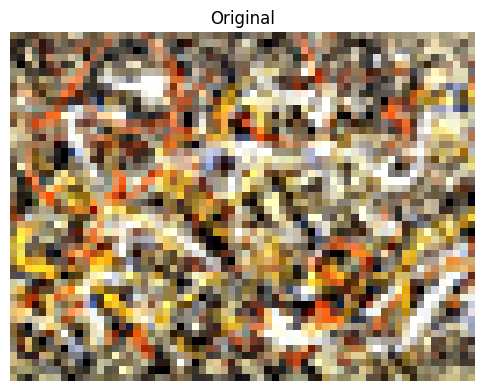

Found 1 clusters


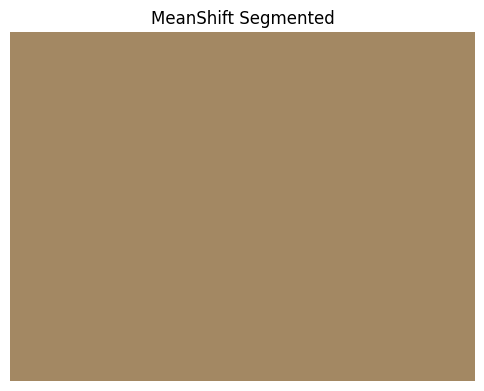

Saved segmented image to output/meanshift_pollock.png
Using image: starrynight.png


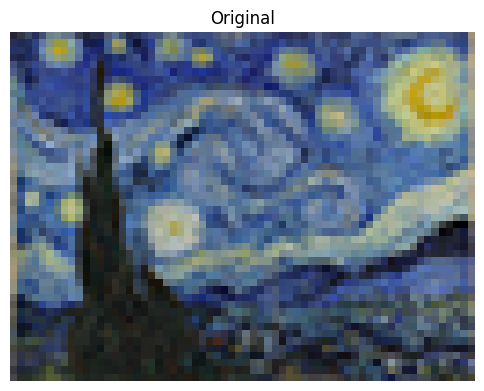

Found 4 clusters


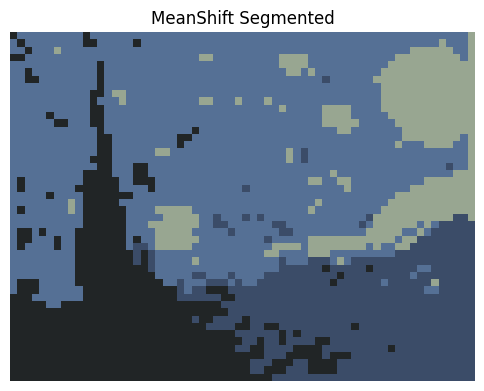

Saved segmented image to output/meanshift_starrynight.png


In [19]:
# apply MeanShift to a single image from "instancias/" and show/save results
# (uses read_image, show_image, save_image, meanshift_segment already defined)

# pick first image found
img_files = [f for f in os.listdir("instancias/") if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
if not img_files:
    print("No images found in instancias/")
else:
    for file_name in img_files:
        print(f"Using image: {file_name}")

        img = read_image(f"instancias/{file_name}")  # RGB uint8

        # show original
        show_image(img, title="Original")

        # run MeanShift (tune parameters as needed)
        segmented, labels, centers = meanshift_segment(img,
                                                    bandwidth=None,
                                                    sample_fraction=0.05,
                                                    use_spatial=True,
                                                    spatial_scale=0.75,
                                                    bin_seeding=True)

        print(f"Found {len(centers)} clusters")

        # show segmented result
        show_image(segmented, title="MeanShift Segmented")

        # save segmented result
        out_path = f"output/meanshift_{file_name}"
        save_image(out_path, segmented)
        print(f"Saved segmented image to {out_path}")